In [1]:
SEQ_LENGTHS = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 
           2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576]

In [2]:
def count_flops_est(model, batch_size=1, sequence_length=1):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle Echo State Transformer (nouvelle implémentation).
    
    Parameters:
    - model: Instance du modèle EST
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    T = sequence_length
    L = model.num_layers  # Nombre de couches
    M = model.memory_units  # Nombre d'unités mémoire
    R = model.memory_dim  # Dimension mémoire
    D = model.attention_dim  # Dimension attention
    I = model.enc_in  # Dimension d'entrée
    
    # Paramètres de sortie selon la tâche
    if hasattr(model.projection, 'out_features'):
        O = model.projection.out_features
    else:
        O = D  # Par défaut
    
    flops_breakdown = {}
    
    # ==================== EMBEDDING LAYER ====================
    
    # Input embedding (DataEmbedding)
    # Approximation: principalement la projection linéaire value_embedding
    flops_breakdown['input_embedding'] = B * T * I * D
    
    # ==================== EST LAYER LEVEL (répété L fois pour T timesteps) ====================
    
    layer_flops = {}
    
    # ==================== MEMORY FORWARD ====================
    
    memory_flops = {}
    
    # Adaptive Leak Rate computation
    # X @ adaptive_lr: [B, M, 1, D] @ [M, D, 1] -> [B, M, 1, 1]
    memory_flops['adaptive_lr_mm'] = B * M * D * 1 * T
    
    # Softmax sur adaptive_lr (division par temperature + softmax)
    memory_flops['adaptive_lr_softmax'] = B * M * 1 * 1 * 3 * T  # exp + sum + div
    
    # Feed computation (sparse matrix multiplication)
    # Estimation basée sur la connectivité fixe
    input_connectivity = model.est_layers[0].memory.input_connectivity
    feed_connections = int(input_connectivity * R)  # Nombre de connexions par colonne
    # Sparse MM: [B, M, 1, D] avec [M, D, R] -> [B, M, 1, R]
    memory_flops['feed_sparse_mm'] = B * M * D * feed_connections * T
    
    # Echo computation (sparse matrix multiplication + bias)
    res_connectivity = model.est_layers[0].memory.res_connectivity
    echo_connections = int(res_connectivity * R)  # Nombre de connexions par colonne
    # Sparse MM: [B, M, 1, R] avec [M, R, R] -> [B, M, 1, R]
    memory_flops['echo_sparse_mm'] = B * M * R * echo_connections * T
    # Addition du biais: [B, M, 1, R] + [M, 1, R]
    memory_flops['echo_bias_add'] = B * M * 1 * R * T
    
    # State update computation
    # (1 - lr) * state: [B, M, 1, 1] * [B, M, 1, R]
    memory_flops['state_update_mul1'] = B * M * 1 * R * T
    # lr * tanh(feed + echo): addition + tanh + multiplication
    memory_flops['feed_echo_add'] = B * M * 1 * R * T  # feed + echo
    memory_flops['tanh'] = B * M * 1 * R * T  # tanh
    memory_flops['state_update_mul2'] = B * M * 1 * R * T  # lr * tanh(...)
    # Final addition: ((1-lr)*state) + lr*tanh(...)
    memory_flops['state_update_final_add'] = B * M * 1 * R * T
    
    # Output computation: new_state @ Wout
    # [B, M, 1, R] @ [M, R, D] -> [B, M, 1, D]
    memory_flops['output_mm'] = B * M * R * D * T
    
    # ==================== ATTENTION MECHANISMS ====================
    
    attention_flops = {}
    
    # Attention on previous states
    # Q = emb @ Wq: [B, 1, 1, D] @ [M, D, D] -> [B, M, 1, D]
    attention_flops['Q_computation'] = B * M * D * D * T
    
    # K = Sout @ Wk: [B, M, M, D] @ [M, D, D] -> [B, M, M, D]
    attention_flops['K_computation'] = B * M * M * D * D * T
    
    # V = Sout @ Wv: [B, M, M, D] @ [M, D, D] -> [B, M, M, D]
    attention_flops['V_computation'] = B * M * M * D * D * T
    
    # Scaled dot product attention: Q @ K^T
    # [B, M, 1, D] @ [B, M, D, M] -> [B, M, 1, M]
    attention_flops['QKT_mm'] = B * M * 1 * D * M * T
    
    # Scale + Softmax
    attention_flops['scale_attention'] = B * M * 1 * M * T
    attention_flops['attention_softmax'] = B * M * 1 * M * 3 * T  # exp + sum + div
    
    # Attention weights @ V: [B, M, 1, M] @ [B, M, M, D] -> [B, M, 1, D]
    attention_flops['attention_V_mm'] = B * M * 1 * M * D * T
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + norm1
    attention_flops['residual_add1'] = B * M * D * T
    # RMS Norm: sqrt(mean(x^2)) et division (approximation: 3 ops par élément)
    attention_flops['norm1'] = B * M * D * 3 * T
    
    # Self-attention on current state
    # SQ, SK, SV computations: [B, M, D] @ [D, D] -> [B, M, D] (x3)
    attention_flops['SQ_computation'] = B * M * D * D * T
    attention_flops['SK_computation'] = B * M * D * D * T
    attention_flops['SV_computation'] = B * M * D * D * T
    
    # Self-attention: SQ @ SK^T: [B, M, D] @ [B, D, M] -> [B, M, M]
    attention_flops['self_QKT_mm'] = B * M * D * M * T
    
    # Scale + Softmax
    attention_flops['self_scale_attention'] = B * M * M * T
    attention_flops['self_attention_softmax'] = B * M * M * 3 * T
    
    # Self-attention weights @ SV: [B, M, M] @ [B, M, D] -> [B, M, D]
    attention_flops['self_attention_V_mm'] = B * M * M * D * T
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + norm2
    attention_flops['residual_add2'] = B * M * D * T
    attention_flops['norm2'] = B * M * D * 3 * T
    
    # ==================== FEED FORWARD ====================
    
    ff_flops = {}
    
    # Reduction: [B, M*D] @ [M*D, D] -> [B, D]
    ff_flops['reduction_mm'] = B * (M * D) * D * T
    
    # Feed forward in: [B, D] @ [D, 4*D] -> [B, 4*D]
    ff_flops['ff_in_mm'] = B * D * (4 * D) * T
    
    # GELU activation (approximation: 4 ops par élément)
    ff_flops['gelu'] = B * (4 * D) * 4 * T
    
    # Feed forward out: [B, 4*D] @ [4*D, D] -> [B, D]
    ff_flops['ff_out_mm'] = B * (4 * D) * D * T
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + norm3
    ff_flops['residual_add3'] = B * D * T
    ff_flops['norm3'] = B * D * 3 * T
    
    # ==================== ASSEMBLY LAYER FLOPS ====================
    
    # Somme des FLOPs pour une couche EST
    layer_total = (sum(memory_flops.values()) + 
                  sum(attention_flops.values()) + 
                  sum(ff_flops.values()))
    
    layer_flops['memory'] = memory_flops
    layer_flops['attention'] = attention_flops
    layer_flops['feed_forward'] = ff_flops
    layer_flops['total_per_layer'] = layer_total
    
    # ==================== OUTPUT PROJECTION ====================
    
    # Classification: flatten + projection
    if model.task_name == 'classification':
        # Flatten: [B, T, D] -> [B, T*D] (pas de FLOPs)
        # Projection: [B, T*D] @ [T*D, O] -> [B, O]
        flops_breakdown['output_projection'] = B * (T * D) * O
        # GELU + Dropout (pas de FLOPs pour dropout)
        flops_breakdown['output_activation'] = B * (T * D) * 2  # GELU approximation
    else:
        # Direct projection: [B, T, D] @ [D, O] -> [B, T, O]
        flops_breakdown['output_projection'] = B * T * D * O
        flops_breakdown['output_activation'] = 0
    
    # ==================== NORMALIZATION (si applicable) ====================
    
    normalization_flops = 0
    if model.task_name in ['long_term_forecast', 'short_term_forecast']:
        # Mean computation: B * T * D operations
        normalization_flops += B * T * D
        # Std computation: B * T * D operations (var + sqrt)
        normalization_flops += B * T * D * 2
        # Normalization: B * T * D operations (subtract + divide)
        normalization_flops += B * T * D * 2
        # Denormalization: B * T * D operations (multiply + add)
        normalization_flops += B * T * D * 2
    
    flops_breakdown['normalization'] = normalization_flops
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['layers'] = layer_flops
    flops_breakdown['total_layers'] = layer_total * L  # Multiplier par le nombre de couches
    
    total_flops = (flops_breakdown['input_embedding'] + 
                  flops_breakdown['total_layers'] + 
                  flops_breakdown['output_projection'] +
                  flops_breakdown['output_activation'] +
                  flops_breakdown['normalization'])
    
    flops_breakdown['total'] = total_flops
    
    return flops_breakdown, total_flops

def print_flops_breakdown_est(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour EST v2.
    
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"ECHO STATE TRANSFORMER V2 - FLOPs BREAKDOWN")
    print("="*60)
    
    print(f"Input Embedding: {flops_breakdown['input_embedding']:,} FLOPs")
    print(f"Output Projection: {flops_breakdown['output_projection']:,} FLOPs")
    if flops_breakdown['output_activation'] > 0:
        print(f"Output Activation: {flops_breakdown['output_activation']:,} FLOPs")
    if flops_breakdown['normalization'] > 0:
        print(f"Normalization: {flops_breakdown['normalization']:,} FLOPs")
    
    print(f"\nPer Layer FLOPs: {flops_breakdown['layers']['total_per_layer']:,}")
    print(f"Total Layers FLOPs: {flops_breakdown['total_layers']:,}")
    
    print(f"\n--- Layer Breakdown ---")
    memory_total = sum(flops_breakdown['layers']['memory'].values())
    attention_total = sum(flops_breakdown['layers']['attention'].values())
    ff_total = sum(flops_breakdown['layers']['feed_forward'].values())
    
    layer_total = flops_breakdown['layers']['total_per_layer']
    print(f"Memory Operations: {memory_total:,} FLOPs ({memory_total/layer_total*100:.1f}%)")
    print(f"Attention Mechanisms: {attention_total:,} FLOPs ({attention_total/layer_total*100:.1f}%)")
    print(f"Feed Forward: {ff_total:,} FLOPs ({ff_total/layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed Memory Breakdown ---")
    for component, flops in flops_breakdown['layers']['memory'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)



# Test de la nouvelle fonction count_flops_est_v2 avec le modèle EST
from models.EST import Model as EST

# Configuration du modèle EST (adaptée à votre nouvelle implémentation)
configs_est = type('Config', (), {
    'task_name': '',
    'pred_len': 10, 
    'seq_len': 10,
    'num_layers': 1,  # Moins de couches
    'd_model': 16,   # Dimension plus petite
    'dropout': 0.0,
    'memory_units': 4,  # Moins d'unités
    'memory_dim': 36,   # Dimension plus petite
    'memory_connectivity': 0.2,
    'enc_in': 10,
    'c_out': 10,
    'num_class': 10,
    'embed': 'timeF',
    'freq': 'h'
})()

# Créer le modèle EST
model_est = EST(configs_est)
print("Model parameters:", sum(p.numel() for p in model_est.parameters()))

# Test avec un exemple
batch_size = 32
sequence_length = 96
flops_breakdown, total_flops = count_flops_est(model_est, batch_size=batch_size, sequence_length=sequence_length)

# Afficher les résultats détaillés
print_flops_breakdown_est(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_est = []

for seq_len in SEQ_LENGTHS:
    flops_breakdown, total_flops = count_flops_est(model_est, batch_size=10, sequence_length=seq_len)
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_est.append(total_flops)


Model parameters: 10143
ECHO STATE TRANSFORMER V2 - FLOPs BREAKDOWN
Input Embedding: 491,520 FLOPs
Output Projection: 491,520 FLOPs

Per Layer FLOPs: 67,719,168
Total Layers FLOPs: 67,719,168

--- Layer Breakdown ---
Memory Operations: 14,438,400 FLOPs (21.3%)
Attention Mechanisms: 42,860,544 FLOPs (63.3%)
Feed Forward: 10,420,224 FLOPs (15.4%)

--- Detailed Memory Breakdown ---
  adaptive_lr_mm: 196,608 FLOPs
  adaptive_lr_softmax: 36,864 FLOPs
  feed_sparse_mm: 1,376,256 FLOPs
  echo_sparse_mm: 3,096,576 FLOPs
  echo_bias_add: 442,368 FLOPs
  state_update_mul1: 442,368 FLOPs
  feed_echo_add: 442,368 FLOPs
  tanh: 442,368 FLOPs
  state_update_mul2: 442,368 FLOPs
  state_update_final_add: 442,368 FLOPs
  output_mm: 7,077,888 FLOPs
TOTAL FLOPs: 68,702,208
TOTAL GFLOPs: 0.069

=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===
Sequence Length:    2, Total FLOPs:      447,280, GFLOPs:    0.000
Sequence Length:    4, Total FLOPs:      894,560, GFLOPs:    0.001
Sequence Length:    8, Total

In [3]:
def count_flops_transformer_vanilla(model, batch_size=1, sequence_length=1, configs={}):
    """
    Compte les FLOPs (Floating Point Operations) pour le modèle Transformer Vanilla.
    
    Parameters:
    - model: Instance du modèle Transformer
    - batch_size: Taille du batch
    - sequence_length: Longueur de la séquence
    
    Returns:
    - dict: Dictionnaire détaillé des FLOPs par composant
    - int: Total des FLOPs
    """
    
    # Paramètres du modèle
    B = batch_size
    S = sequence_length  # Sequence length

    # Récupérer les paramètres depuis le modèle
    # Encoder parameters
    encoder_layers = configs.get('e_layers')
    d_model = configs.get('d_model')
    n_heads = configs.get('n_heads')  # Valeur par défaut si non spécifié
    
    # Pour d_ff, on regarde les conv layers (conv1 et conv2)
    if encoder_layers > 0:
        d_ff = configs.get('d_ff')
    else:
        d_ff = d_model * 4

    I = configs.get('enc_in')  # Input features
    
    # Output dimension selon la tâche
    if model.task_name == 'classification':
        O = model.projection.out_features
    elif hasattr(model, 'projection'):
        O = model.projection.out_features
    elif model.task_name in ['long_term_forecast', 'short_term_forecast'] and hasattr(model, 'decoder'):
        O = model.decoder.projection.out_features
    else:
        O = d_model
    
    # Dimension par tête d'attention
    head_dim = d_model // n_heads
    
    flops_breakdown = {}
    
    # ==================== INPUT EMBEDDING ====================
    
    # Input embedding: Conv1d tokenization
    # Conv1d: [B, I, S] -> [B, d_model, S] avec kernel_size=3, padding=1
    conv_kernel_size = model.enc_embedding.value_embedding.tokenConv.kernel_size[0]
    flops_breakdown['input_embedding'] = B * S * I * d_model * conv_kernel_size
    
    # Positional embedding (pas de FLOPs, juste addition)
    # Temporal embedding: Linear layer [4 -> d_model]
    temporal_features = model.enc_embedding.temporal_embedding.embed.in_features
    flops_breakdown['positional_temporal_embedding'] = B * S * temporal_features * d_model
    
    # ==================== ENCODER LAYERS ====================
    
    encoder_layer_flops = {}
    
    # ==================== MULTI-HEAD ATTENTION ====================
    
    attention_flops = {}
    
    # Query, Key, Value projections
    # Input: [B, S, d_model] -> Output: [B, S, d_model] (pour chacune des 3 projections)
    attention_flops['Q_projection'] = B * S * d_model * d_model
    attention_flops['K_projection'] = B * S * d_model * d_model
    attention_flops['V_projection'] = B * S * d_model * d_model
    
    # Reshape pour multi-head: [B, S, d_model] -> [B, n_heads, S, head_dim]
    # Pas de FLOPs, juste un reshape
    
    # Attention scores: Q @ K^T
    # Q: [B, n_heads, S, head_dim], K^T: [B, n_heads, head_dim, S] -> [B, n_heads, S, S]
    attention_flops['attention_scores'] = B * n_heads * S * head_dim * S
    
    # Scale by sqrt(head_dim)
    attention_flops['scale_attention'] = B * n_heads * S * S
    
    # Softmax sur la dimension des clés (S)
    # Approximation: exp + sum + divide = 3 opérations par élément
    attention_flops['attention_softmax'] = B * n_heads * S * S * 3
    
    # Dropout (pas de FLOPs)
    
    # Attention weights @ V: [B, n_heads, S, S] @ [B, n_heads, S, head_dim] -> [B, n_heads, S, head_dim]
    attention_flops['attention_values'] = B * n_heads * S * S * head_dim
    
    # Concatenate heads: [B, n_heads, S, head_dim] -> [B, S, d_model]
    # Pas de FLOPs, juste un reshape
    
    # Output projection: [B, S, d_model] @ [d_model, d_model] -> [B, S, d_model]
    attention_flops['output_projection'] = B * S * d_model * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + LayerNorm1
    attention_flops['residual_add'] = B * S * d_model
    attention_flops['layer_norm1'] = B * S * d_model * 3  # mean, var, normalize
    
    # ==================== FEED FORWARD NETWORK (Conv-based) ====================
    
    feedforward_flops = {}
    
    # Conv1: [B, d_model, S] -> [B, d_ff, S] avec kernel_size=1
    feedforward_flops['conv1'] = B * S * d_model * d_ff
    
    # Activation (GELU)
    # Approximation: 2 opérations par élément pour GELU
    feedforward_flops['activation'] = B * S * d_ff * 2
    
    # Dropout (pas de FLOPs)
    
    # Conv2: [B, d_ff, S] -> [B, d_model, S] avec kernel_size=1
    feedforward_flops['conv2'] = B * S * d_ff * d_model
    
    # Dropout (pas de FLOPs)
    
    # Residual connection + LayerNorm2
    feedforward_flops['residual_add'] = B * S * d_model
    feedforward_flops['layer_norm2'] = B * S * d_model * 3
    
    # ==================== ASSEMBLY ENCODER LAYER FLOPS ====================
    
    # Somme des FLOPs pour une couche d'encodeur
    encoder_layer_total = sum(attention_flops.values()) + sum(feedforward_flops.values())
    
    encoder_layer_flops['attention'] = attention_flops
    encoder_layer_flops['feedforward'] = feedforward_flops
    encoder_layer_flops['total_per_layer'] = encoder_layer_total
    
    # ==================== LAYER NORM FINALE ENCODER ====================
    
    encoder_norm_flops = 0
    if hasattr(model.encoder, 'norm') and model.encoder.norm is not None:
        encoder_norm_flops = B * S * d_model * 3
    
    # ==================== DECODER (si applicable) ====================
    
    decoder_flops = 0
    decoder_layer_flops = {}
    
    if model.task_name in ['long_term_forecast', 'short_term_forecast'] and hasattr(model, 'decoder'):
        # Paramètres decoder
        decoder_layers = len(model.decoder.layers) if hasattr(model.decoder, 'layers') else 0
        
        if decoder_layers > 0:
            # Dec embedding (similaire à enc_embedding)
            dec_embedding_flops = B * S * I * d_model * conv_kernel_size + B * S * temporal_features * d_model
            
            # Pour chaque couche decoder (structure similaire à l'encoder)
            decoder_attention_flops = {}
            
            # Self-attention (avec masque causal)
            decoder_attention_flops['self_Q_proj'] = B * S * d_model * d_model
            decoder_attention_flops['self_K_proj'] = B * S * d_model * d_model
            decoder_attention_flops['self_V_proj'] = B * S * d_model * d_model
            decoder_attention_flops['self_attention_scores'] = B * n_heads * S * head_dim * S
            decoder_attention_flops['self_scale_attention'] = B * n_heads * S * S
            decoder_attention_flops['self_attention_softmax'] = B * n_heads * S * S * 3
            decoder_attention_flops['self_attention_values'] = B * n_heads * S * S * head_dim
            decoder_attention_flops['self_output_proj'] = B * S * d_model * d_model
            decoder_attention_flops['self_residual'] = B * S * d_model
            decoder_attention_flops['self_norm1'] = B * S * d_model * 3
            
            # Cross-attention (decoder vers encoder)
            decoder_attention_flops['cross_Q_proj'] = B * S * d_model * d_model
            decoder_attention_flops['cross_K_proj'] = B * S * d_model * d_model
            decoder_attention_flops['cross_V_proj'] = B * S * d_model * d_model
            decoder_attention_flops['cross_attention_scores'] = B * n_heads * S * head_dim * S
            decoder_attention_flops['cross_scale_attention'] = B * n_heads * S * S
            decoder_attention_flops['cross_attention_softmax'] = B * n_heads * S * S * 3
            decoder_attention_flops['cross_attention_values'] = B * n_heads * S * S * head_dim
            decoder_attention_flops['cross_output_proj'] = B * S * d_model * d_model
            decoder_attention_flops['cross_residual'] = B * S * d_model
            decoder_attention_flops['cross_norm2'] = B * S * d_model * 3
            
            # Feed forward decoder (Conv-based)
            decoder_ff_flops = {}
            decoder_ff_flops['conv1'] = B * S * d_model * d_ff
            decoder_ff_flops['activation'] = B * S * d_ff * 2
            decoder_ff_flops['conv2'] = B * S * d_ff * d_model
            decoder_ff_flops['residual_add'] = B * S * d_model
            decoder_ff_flops['layer_norm3'] = B * S * d_model * 3
            
            # Total par couche decoder
            decoder_layer_total = sum(decoder_attention_flops.values()) + sum(decoder_ff_flops.values())
            
            decoder_layer_flops['attention'] = decoder_attention_flops
            decoder_layer_flops['feedforward'] = decoder_ff_flops
            decoder_layer_flops['total_per_layer'] = decoder_layer_total
            
            # Total decoder
            decoder_flops = (dec_embedding_flops + 
                            decoder_layer_total * decoder_layers + 
                            B * S * d_model * 3)  # Norm finale
            
            # Projection finale
            decoder_projection_flops = B * S * d_model * O
            
            flops_breakdown['dec_embedding'] = dec_embedding_flops
            flops_breakdown['decoder_layers'] = decoder_layer_total * decoder_layers
            flops_breakdown['decoder_projection'] = decoder_projection_flops
    
    # ==================== OUTPUT PROJECTION ====================
    
    output_flops = 0
    
    if model.task_name == 'classification':
        # Flatten + GELU + Dropout + Projection
        # output = output.reshape(B, -1): pas de FLOPs
        # GELU: [B, S * d_model]
        gelu_flops = B * S * d_model * 2
        # Projection: [B, S * d_model] @ [S * d_model, num_classes] -> [B, num_classes]
        projection_flops = B * (S * d_model) * O
        
        output_flops = gelu_flops + projection_flops
        
        flops_breakdown['output_activation'] = gelu_flops
        flops_breakdown['output_projection'] = projection_flops
        
    elif model.task_name in ['imputation', 'anomaly_detection']:
        # Direct projection: [B, S, d_model] @ [d_model, O] -> [B, S, O]
        output_flops = B * S * d_model * O
        flops_breakdown['output_projection'] = output_flops
    
    # ==================== TOTAL CALCULATION ====================
    
    flops_breakdown['input_embedding'] = flops_breakdown['input_embedding']
    flops_breakdown['positional_temporal_embedding'] = flops_breakdown['positional_temporal_embedding']
    flops_breakdown['encoder_layers'] = encoder_layer_flops
    flops_breakdown['total_encoder_layers'] = encoder_layer_total * encoder_layers
    flops_breakdown['encoder_norm'] = encoder_norm_flops
    
    if decoder_flops > 0:
        flops_breakdown['decoder_layers_detail'] = decoder_layer_flops
        flops_breakdown['total_decoder'] = decoder_flops
    
    total_flops = (flops_breakdown['input_embedding'] + 
                  flops_breakdown['positional_temporal_embedding'] +
                  flops_breakdown['total_encoder_layers'] + 
                  flops_breakdown['encoder_norm'] +
                  decoder_flops +
                  output_flops)
    
    flops_breakdown['total'] = total_flops
    
    return flops_breakdown, total_flops

def print_flops_breakdown_transformer_vanilla(flops_breakdown, total_flops):
    """
    Affiche un résumé détaillé des FLOPs pour le Transformer Vanilla.
    
    Parameters:
    - flops_breakdown: Dictionnaire des FLOPs par composant
    - total_flops: Total des FLOPs
    """
    print("="*60)
    print(f"TRANSFORMER VANILLA - FLOPs BREAKDOWN")
    print("="*60)
    
    print(f"Input Embedding: {flops_breakdown['input_embedding']:,} FLOPs")
    print(f"Positional/Temporal Embedding: {flops_breakdown['positional_temporal_embedding']:,} FLOPs")
    print(f"Encoder Norm: {flops_breakdown['encoder_norm']:,} FLOPs")
    
    if 'output_projection' in flops_breakdown:
        print(f"Output Projection: {flops_breakdown['output_projection']:,} FLOPs")
    if 'output_activation' in flops_breakdown:
        print(f"Output Activation: {flops_breakdown['output_activation']:,} FLOPs")
    
    print(f"\n=== ENCODER ===")
    print(f"Per Encoder Layer FLOPs: {flops_breakdown['encoder_layers']['total_per_layer']:,}")
    print(f"Total Encoder Layers FLOPs: {flops_breakdown['total_encoder_layers']:,}")
    
    print(f"\n--- Encoder Layer Breakdown ---")
    encoder_attention_total = sum(flops_breakdown['encoder_layers']['attention'].values())
    encoder_ff_total = sum(flops_breakdown['encoder_layers']['feedforward'].values())
    encoder_layer_total = flops_breakdown['encoder_layers']['total_per_layer']
    
    print(f"Multi-Head Attention: {encoder_attention_total:,} FLOPs ({encoder_attention_total/encoder_layer_total*100:.1f}%)")
    print(f"Feed Forward Network (Conv): {encoder_ff_total:,} FLOPs ({encoder_ff_total/encoder_layer_total*100:.1f}%)")
    
    # Decoder si présent
    if 'total_decoder' in flops_breakdown:
        print(f"\n=== DECODER ===")
        print(f"Dec Embedding: {flops_breakdown['dec_embedding']:,} FLOPs")
        print(f"Total Decoder Layers: {flops_breakdown['decoder_layers']:,} FLOPs")
        print(f"Decoder Projection: {flops_breakdown['decoder_projection']:,} FLOPs")
        print(f"Total Decoder: {flops_breakdown['total_decoder']:,} FLOPs")
        
        if 'decoder_layers_detail' in flops_breakdown:
            decoder_attention_total = sum(flops_breakdown['decoder_layers_detail']['attention'].values())
            decoder_ff_total = sum(flops_breakdown['decoder_layers_detail']['feedforward'].values())
            decoder_layer_total = flops_breakdown['decoder_layers_detail']['total_per_layer']
            
            print(f"\n--- Decoder Layer Breakdown ---")
            print(f"Attention Mechanisms: {decoder_attention_total:,} FLOPs ({decoder_attention_total/decoder_layer_total*100:.1f}%)")
            print(f"Feed Forward Network: {decoder_ff_total:,} FLOPs ({decoder_ff_total/decoder_layer_total*100:.1f}%)")
    
    print(f"\n--- Detailed Encoder Attention Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['attention'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print(f"\n--- Detailed Encoder Feed Forward Breakdown ---")
    for component, flops in flops_breakdown['encoder_layers']['feedforward'].items():
        print(f"  {component}: {flops:,} FLOPs")
    
    print("="*60)
    print(f"TOTAL FLOPs: {total_flops:,}")
    print(f"TOTAL GFLOPs: {total_flops / 1e9:.3f}")
    print("="*60)

# Test du modèle Transformer Vanilla
from models.Transformer import Model as TransformerVanilla

# Configuration pour le modèle Transformer
conf_transformer = {
    'task_name': '',
    'pred_len': 1,
    'seq_len': 10,
    'enc_in': 10,        # Features d'entrée
    'dec_in': 10,        # Features decoder (si applicable)
    'c_out': 1,          # Features de sortie
    'num_class': 10,     # Nombre de classes pour classification
    'd_model': 64,       # Dimension du modèle
    'n_heads': 8,        # Nombre de têtes d'attention
    'd_ff': 256,         # Dimension feedforward
    'e_layers': 2,       # Nombre de couches encoder
    'd_layers': 1,       # Nombre de couches decoder
    'factor': 5,         # Facteur pour attention
    'dropout': 0.1,
    'activation': 'gelu',
    'embed': 'timeF',
    'freq': 'h'
}
configs_transformer = type('Config', (), conf_transformer)()

# Créer le modèle
model_transformer = TransformerVanilla(configs_transformer)
print("Model parameters:", sum(p.numel() for p in model_transformer.parameters()))

print("=== MODÈLE TRANSFORMER VANILLA CRÉÉ ===")
print(f"Task: {model_transformer.task_name}")
if hasattr(model_transformer, 'decoder'):
    print(f"Decoder layers: {len(model_transformer.decoder.attn_layers)}")

# Test des FLOPs
batch_size = 32
sequence_length = 96

flops_breakdown, total_flops = count_flops_transformer_vanilla(
    model_transformer, batch_size=batch_size, sequence_length=sequence_length, configs=conf_transformer
)

# Afficher les résultats
print_flops_breakdown_transformer_vanilla(flops_breakdown, total_flops)

# Test avec différentes longueurs de séquence
print(f"\n=== TEST AVEC DIFFÉRENTES LONGUEURS DE SÉQUENCE ===")
flops_transformer_vanilla = []

for seq_len in SEQ_LENGTHS:
    flops_breakdown, total_flops = count_flops_transformer_vanilla(
        model_transformer, batch_size=10, sequence_length=seq_len, configs=conf_transformer
    )
    print(f"Sequence Length: {seq_len:4d}, Total FLOPs: {total_flops:12,}, GFLOPs: {total_flops/1e9:8.3f}")
    flops_transformer_vanilla.append(total_flops)

/Users/naowak/Thesis/code/Time-Series-Library/tsl_venv/lib/python3.11/site-packages/local_attention/rotary.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/Users/naowak/Thesis/code/Time-Series-Library/tsl_venv/lib/python3.11/site-packages/local_attention/rotary.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


Model parameters: 102272
=== MODÈLE TRANSFORMER VANILLA CRÉÉ ===
Task: 
TRANSFORMER VANILLA - FLOPs BREAKDOWN
Input Embedding: 5,898,240 FLOPs
Positional/Temporal Embedding: 786,432 FLOPs
Encoder Norm: 589,824 FLOPs

=== ENCODER ===
Per Encoder Layer FLOPs: 201,326,592
Total Encoder Layers FLOPs: 402,653,184

--- Encoder Layer Breakdown ---
Multi-Head Attention: 98,304,000 FLOPs (48.8%)
Feed Forward Network (Conv): 103,022,592 FLOPs (51.2%)

--- Detailed Encoder Attention Breakdown ---
  Q_projection: 12,582,912 FLOPs
  K_projection: 12,582,912 FLOPs
  V_projection: 12,582,912 FLOPs
  attention_scores: 18,874,368 FLOPs
  scale_attention: 2,359,296 FLOPs
  attention_softmax: 7,077,888 FLOPs
  attention_values: 18,874,368 FLOPs
  output_projection: 12,582,912 FLOPs
  residual_add: 196,608 FLOPs
  layer_norm1: 589,824 FLOPs

--- Detailed Encoder Feed Forward Breakdown ---
  conv1: 50,331,648 FLOPs
  activation: 1,572,864 FLOPs
  conv2: 50,331,648 FLOPs
  residual_add: 196,608 FLOPs
  laye

In [4]:
flops_est, flops_transformer_vanilla

([447280,
  894560,
  1789120,
  3578240,
  7156480,
  14312960,
  28625920,
  57251840,
  114503680,
  229007360,
  458014720,
  916029440,
  1832058880,
  3664117760,
  7328235520,
  14656471040,
  29312942080,
  58625884160,
  117251768320,
  234503536640],
 [2067200,
  4160000,
  8422400,
  17254400,
  36147200,
  78848000,
  183910400,
  472678400,
  1364787200,
  4407296000,
  15525478400,
  57894502400,
  223163187200,
  875823104000,
  3469633126400,
  13811213926400,
  55110218547200,
  220171599872000,
  880147850854400,
  3519514306150400])

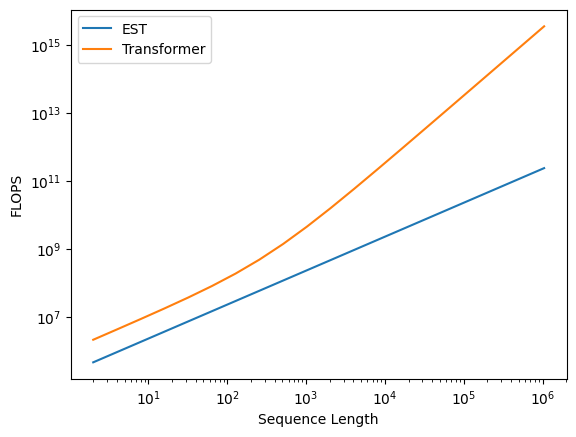

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.lineplot(x=SEQ_LENGTHS, y=flops_est, label='EST')
sns.lineplot(x=SEQ_LENGTHS, y=flops_transformer_vanilla, label='Transformer')
# sns.lineplot(x=SEQ_LENGTHS, y=flops_lstm, label='LSTM')
plt.xlabel('Sequence Length')
plt.ylabel('FLOPS')
plt.yscale('log')
plt.xscale('log')